In [1]:
import sys
sys.path.append("../../diffusion_models")
from models.sampler import DiffusionSampler
from models.unet import UNet
from models.diffusion import DiffusionModel, ForwardDiffusion
import torch
import torch.nn as nn
import os
import json
import torchvision
from time import time

config = None
with open("config_dutifulpond10.json", "r") as f:
    config = json.load(f)
ckpt_path = f"/home/lionel/Documents/checkpoints/dutiful-pond-10-checkpoint32.pt"
device = torch.device("cuda")
backbone = UNet(
    num_encoding_blocks = config["backbone_enc_depth"]["value"],
    in_channels = config["in_channels"]["value"],
    kernel_size = config["kernel_size"]["value"],
    time_emb_size = config["time_enc_dim"]["value"],
    dropout = 0.0,
    activation = nn.SiLU,
    verbose = False,
    init_channels = config["unet_init_channels"]["value"],
    attention = False
)
fwd_diff = ForwardDiffusion(
    timesteps = config["max_timesteps"]["value"],
    type = config["schedule_type"]["value"]
)
model = DiffusionModel(
    backbone = backbone,
    fwd_diff = fwd_diff,
    img_size = config["img_size"]["value"],
    time_enc_dim = config["time_enc_dim"]["value"]
)
sampler = DiffusionSampler(
    model,
    ckpt_path,
    "cuda",
    mixed_precision = True
).to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacty of 1.95 GiB of which 1.06 MiB is free. Process 75091 has 1.83 GiB memory in use. Including non-PyTorch memory, this process has 110.00 MiB memory in use. Of the allocated memory 75.97 MiB is allocated by PyTorch, and 2.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
time1 = time()
out = sampler.sample(16)
print(time() - time1)

Max Memory Allocated: 1.42
486.26550006866455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


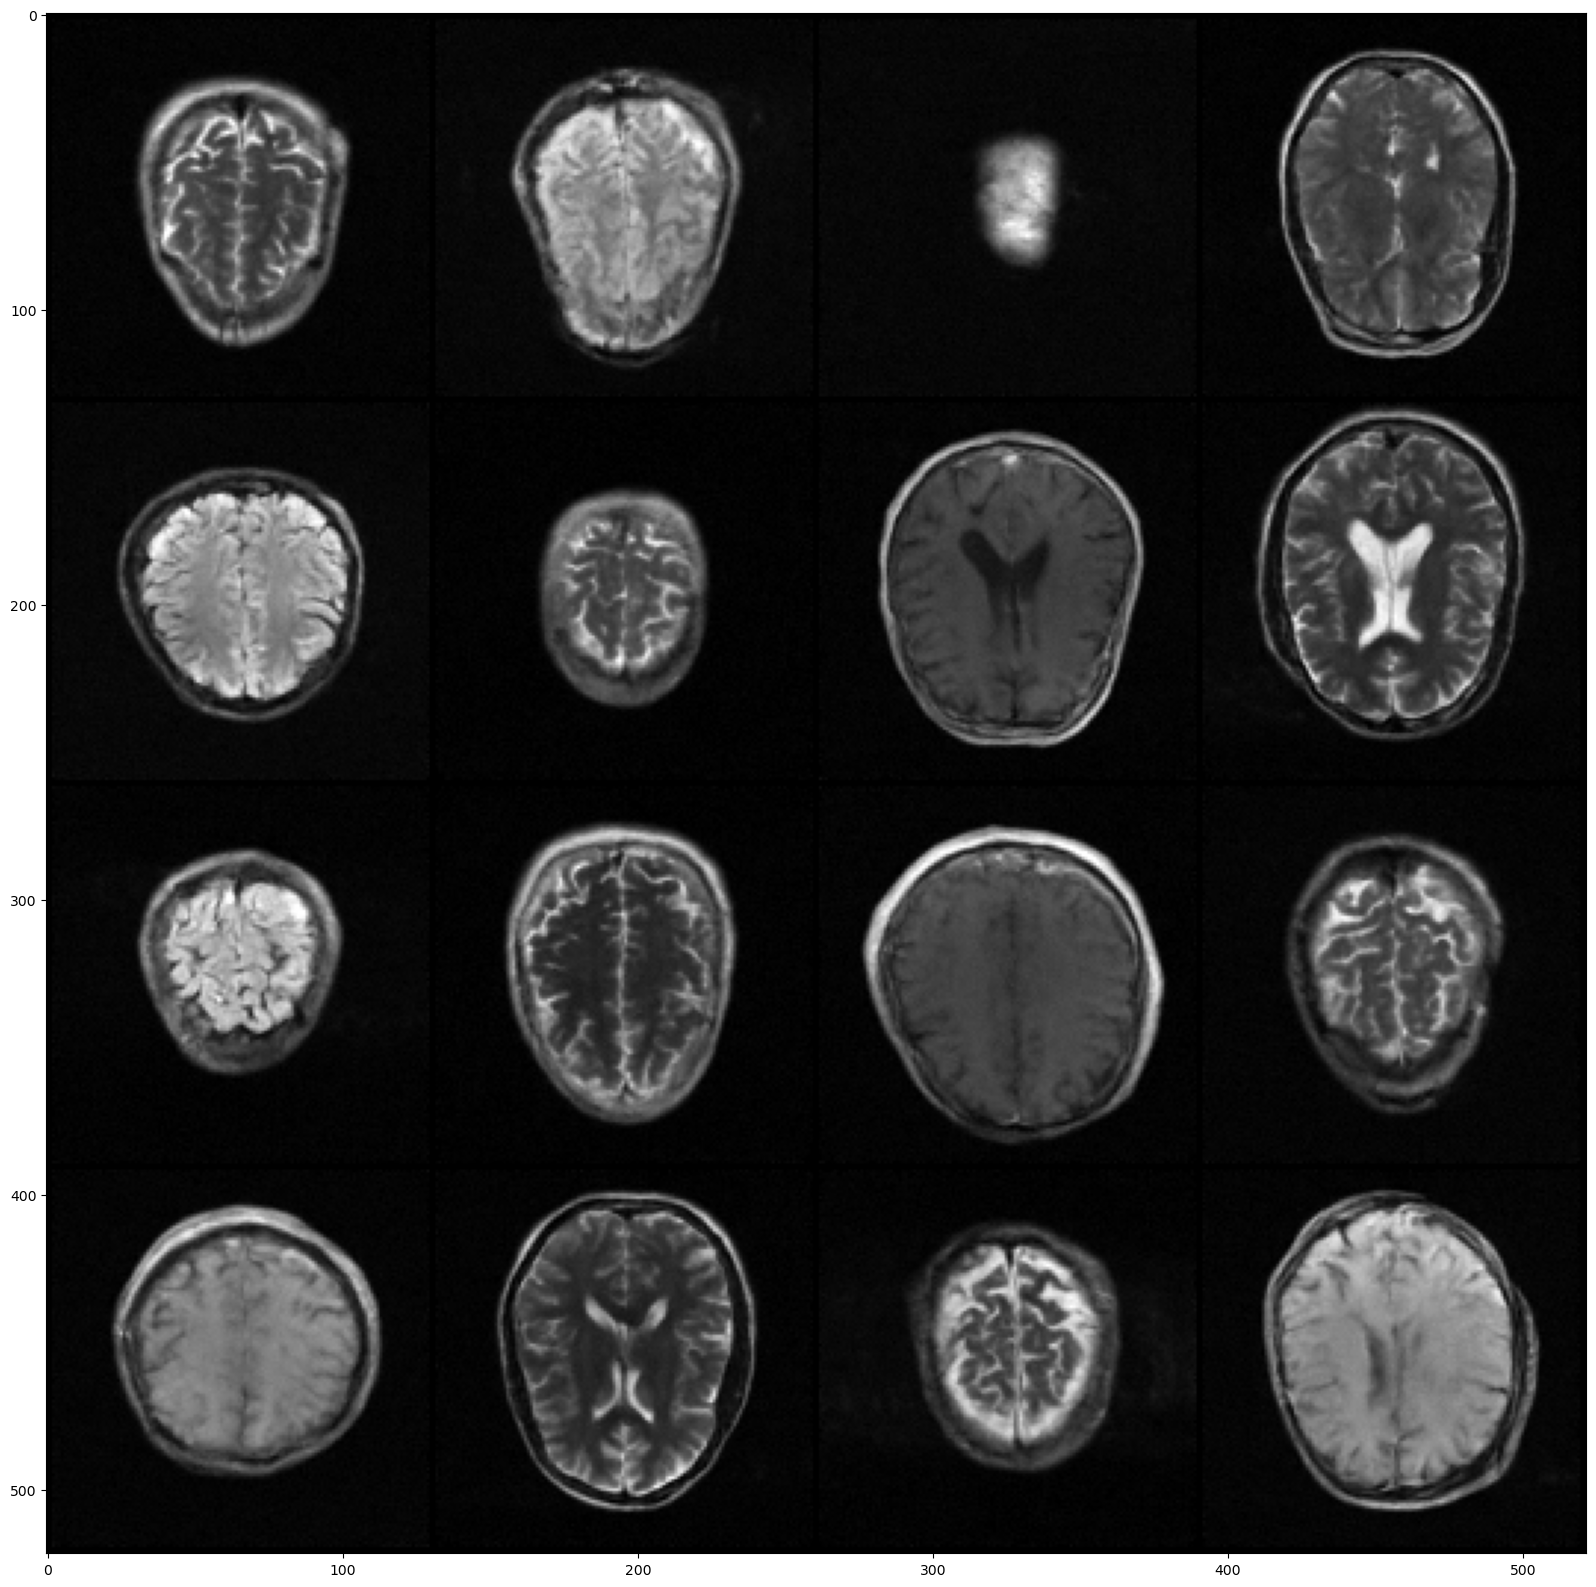

In [18]:
import matplotlib.pyplot as plt

out = out.to("cpu")
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(torchvision.utils.make_grid(out, nrow=4).permute(1,2,0))

In [19]:
beta = sampler.model.fwd_diff.betas[-1].view(-1,1,1,1)
x = sampler.model.init_noise(4) * torch.sqrt(beta)
intermediates = []
for i in reversed(range(1, sampler.model.fwd_diff.timesteps)):
    t = i * torch.ones((4), dtype=torch.long, device=torch.device("cuda"))
    x = sampler.model.denoise_singlestep(x, t)
    if i % 20 == 0:
        intermediates.append(x)

In [1]:
intermediates2 = [torchvision.utils.make_grid(elem.cpu()) for elem in intermediates]
plt.imshow(torchvision.utils.make_grid(torch.stack(intermediates2)).permute(1,2,0))

NameError: name 'intermediates' is not defined